# Setup and load variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
thresh = 10**6 # sample expression threshold
species = "mouse"

In [3]:
expr = pd.read_csv(f"../../data/prepared/{species}.tsv.gz", sep="\t", header=0, index_col=[0,1])
print(expr.shape)
# rename the first column to "celltype"
idx = list(expr.index.names)
idx[0] = 'celltype'
expr.index.names = idx
expr.T.index.names = ['Gene']
expr.head().iloc[:,:5]

(746, 31053)


Gene                Xkr4  Gm1992  Gm37381  Rp1  Sox17
celltype donor_id                                    
E_1      F003      19135    1572        6   38      2
         F004      11089     752       11   21      0
         F005      32075    2540       17   63      0
         F006      27934    1958       12   50      4
         F007      13429     883        2   32      0

# First, filter samples

How many samples have fewer than $10^6$ reads?

In [4]:
celltype_sum = expr.sum(axis=1)
celltype_sum

celltype  donor_id
E_1       F003        19356511
          F004        12768410
          F005        29302841
          F006        29079694
          F007        11659998
                        ...   
N_9       M003          303907
          M004          281249
          M006           81061
          M007          421062
          M008          338591
Length: 746, dtype: int64

In [5]:
num_celltypes = (celltype_sum > thresh).sum()
num_celltypes

280

(0.0, 10000000.0)

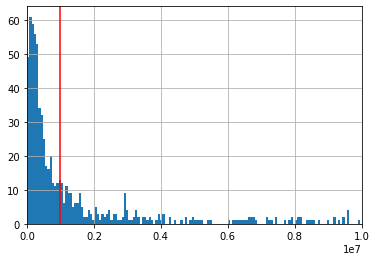

In [6]:
celltype_sum.hist(bins=1000)
plt.axvline(x=thresh, color='red')
plt.xlim([0, 10**7])

In [7]:
expr = expr.iloc[np.where(celltype_sum > thresh)[0]]
expr.shape

(280, 31053)

In [8]:
celltype_sum = celltype_sum[celltype_sum > thresh]
celltype_sum

celltype  donor_id
E_1       F003        19356511
          F004        12768410
          F005        29302841
          F006        29079694
          F007        11659998
                        ...   
N_7       F008         1929613
          M002         1072272
          M003         1318034
          M007         1533796
          M008         1573458
Length: 280, dtype: int64

# Scale to CPM and add pseudocount

In [9]:
cpm = pd.DataFrame((expr.values.T/celltype_sum.values).T, index=expr.index, columns=expr.columns)
cpm = cpm*1e6 + 1
cpm.head().iloc[:,:5]

Gene                      Xkr4     Gm1992   Gm37381       Rp1     Sox17
celltype donor_id                                                      
E_1      F003       989.556254  82.212983  1.309973  2.963164  1.103324
         F004       869.471485  59.895352  1.861501  2.644684  1.000000
         F005      1095.603762  87.681015  1.580149  3.149962  1.000000
         F006       961.601580  68.332208  1.412659  2.719413  1.137553
         F007      1152.715463  76.729001  1.171527  3.744426  1.000000

In [10]:
cpm.sum(axis=1)

celltype  donor_id
E_1       F003        1031053.0
          F004        1031053.0
          F005        1031053.0
          F006        1031053.0
          F007        1031053.0
                        ...    
N_7       F008        1031053.0
          M002        1031053.0
          M003        1031053.0
          M007        1031053.0
          M008        1031053.0
Length: 280, dtype: float64

# Filter genes by CPM

Remove any genes with cumulative $CPM \le 1$ in more than half of the samples.

In [11]:
keep_genes = ((cpm <= 1).sum()/num_celltypes) < 0.5
print(f"Keeping {keep_genes.sum()} genes")
keep_genes

Keeping 19074 genes


Gene
Xkr4               True
Gm1992             True
Gm37381            True
Rp1                True
Sox17             False
                  ...  
AC168977.1        False
AC149090.1         True
CAAA01118383.1     True
Vmn2r122          False
CAAA01147332.1     True
Length: 31053, dtype: bool

In [12]:
cpm = cpm.loc[:,keep_genes]
cpm.shape

(280, 19074)

# Log transform

In [13]:
cpm = np.log(cpm)
cpm.head().iloc[:,:5]

Gene                   Xkr4    Gm1992   Gm37381       Rp1    Mrpl15
celltype donor_id                                                  
E_1      F003      6.897257  4.409313  0.270007  1.086258  3.565450
         F004      6.767886  4.092599  0.621383  0.972552  3.827656
         F005      6.999061  4.473705  0.457519  1.147390  3.519316
         F006      6.868600  4.224381  0.345474  1.000416  3.626714
         F007      7.049876  4.340280  0.158308  1.320268  3.541929

# Scale so that celltypes sum to $log(10^6)$

In [14]:
cpm = cpm.divide(cpm.sum(axis=1), axis=0)*1e6
cpm.head().iloc[:,:5]

Gene                     Xkr4     Gm1992    Gm37381        Rp1     Mrpl15
celltype donor_id                                                        
E_1      F003      150.431298  96.168484   5.888929  23.691612  77.763569
         F004      146.923587  88.845963  13.489568  21.113059  83.094336
         F005      155.846667  99.615089  10.187479  25.548710  78.363895
         F006      152.220075  93.619603   7.656298  22.170951  80.374269
         F007      156.802103  96.535744   3.521052  29.365177  78.778955

# Transpose and write to file

In [15]:
output = f"../../data/prepared/{species}_scaled.tsv.gz"
cpm.to_csv(output, sep="\t")

In [16]:
!zcat {output} | head -n5 | cut -f-5

celltype	donor_id	Xkr4	Gm1992	Gm37381
E_1	F003	150.43129750067914	96.16848379675916	5.888929377329834
E_1	F004	146.9235868165218	88.8459633276744	13.48956824821265
E_1	F005	155.84666684452878	99.61508947243885	10.18747922016923
E_1	F006	152.22007488867078	93.61960315580421	7.656297800779053

gzip: stdout: Broken pipe
